PART 2
Multivariate Regression Implementation

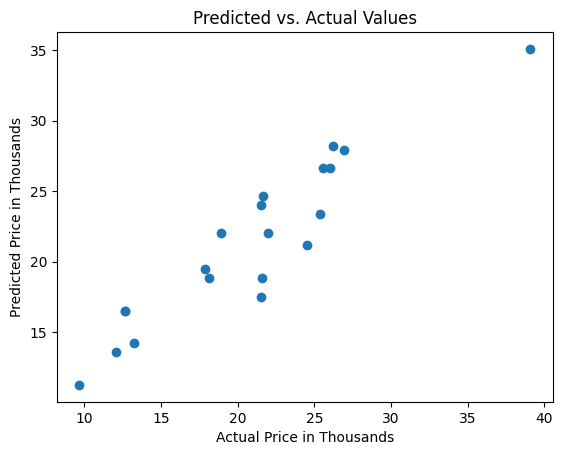

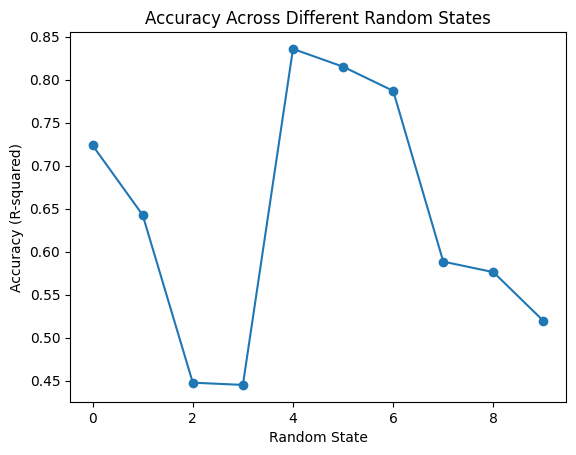

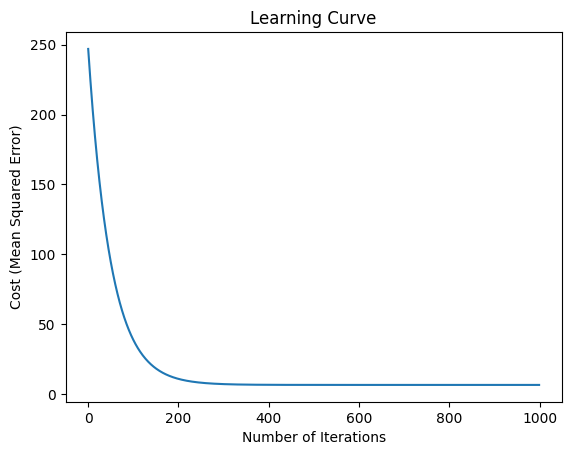

In [6]:
# Function to perform gradient descent and compute cost
def gradient_descent(X, y, theta, learning_rate, num_iterations):
    m = len(y)
    cost_history = []
    for i in range(num_iterations):
        predictions = np.dot(X, theta)
        errors = predictions - y
        gradient = (1 / m) * np.dot(X.T, errors)
        theta -= learning_rate * gradient
        
        # Compute cost
        squared_errors = np.square(errors)
        cost = (1 / (2 * m)) * np.sum(squared_errors)
        cost_history.append(cost)
    return theta, cost_history

# Multivariate Regression Implementation
class MultivariateRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_features, 1))
        self.weights, cost_history = gradient_descent(X, y, self.weights, self.learning_rate, self.n_iters)

    def predict(self, X):
        y_pred = np.dot(X, self.weights)
        return y_pred

# Load the dataset
cars_data = pd.read_csv('cars.csv')

# Preprocess the data
X = cars_data.drop(['Price in Thousands', 'Horsepower'], axis=1).values
y_price = cars_data['Price in Thousands'].values.reshape(-1, 1)
y_horsepower = cars_data['Horsepower'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=28)
X_train_horsepower, X_test_horsepower, y_train_horsepower, y_test_horsepower = train_test_split(X, y_horsepower, test_size=0.2, random_state=28)

# Normalize features
X_train_price_normalized = (X_train_price - X_train_price.mean(axis=0)) / X_train_price.std(axis=0)
X_test_price_normalized = (X_test_price - X_test_price.mean(axis=0)) / X_test_price.std(axis=0)
X_train_horsepower_normalized = (X_train_horsepower - X_train_horsepower.mean(axis=0)) / X_train_horsepower.std(axis=0)
X_test_horsepower_normalized = (X_test_horsepower - X_test_horsepower.mean(axis=0)) / X_test_horsepower.std(axis=0)

# Add bias term (intercept)
X_train_price_normalized_with_bias = np.c_[np.ones((X_train_price_normalized.shape[0], 1)), X_train_price_normalized]
X_test_price_normalized_with_bias = np.c_[np.ones((X_test_price_normalized.shape[0], 1)), X_test_price_normalized]
X_train_horsepower_normalized_with_bias = np.c_[np.ones((X_train_horsepower_normalized.shape[0], 1)), X_train_horsepower_normalized]
X_test_horsepower_normalized_with_bias = np.c_[np.ones((X_test_horsepower_normalized.shape[0], 1)), X_test_horsepower_normalized]

# Train the model for Price in Thousands
model_price = MultivariateRegression()
model_price.fit(X_train_price_normalized_with_bias, y_train_price)
y_pred_price = model_price.predict(X_test_price_normalized_with_bias)

# Train the model for Horsepower
model_horsepower = MultivariateRegression()
model_horsepower.fit(X_train_horsepower_normalized_with_bias, y_train_horsepower)
y_pred_horsepower = model_horsepower.predict(X_test_horsepower_normalized_with_bias)

# Compute Mean Squared Error (MSE) for both models
mse_price_custom = np.mean((y_test_price - y_pred_price) ** 2)
mse_horsepower_custom = np.mean((y_test_horsepower - y_pred_horsepower) ** 2)

print("Mean Squared Error (MSE) for Price in Thousands: {:.4f}".format(mse_price_custom))
print("Mean Squared Error (MSE) for Horsepower: {:.4f}".format(mse_horsepower_custom))

def plot_predictions(y_true_list, y_pred_list, labels):
    fig, axes = plt.subplots(1, len(y_true_list), figsize=(12, 6))

    for i, (y_true, y_pred, label) in enumerate(zip(y_true_list, y_pred_list, labels)):
        axes[i].scatter(y_true, y_pred, label=label)
        axes[i].set_title(f'Comparison between True & Predicted Values\n(for {label})')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot predictions for both Price in Thousands and Horsepower
plot_predictions([y_test_price, y_test_horsepower],
                          [y_pred_price, y_pred_horsepower],
                          ['Price in Thousands', 'Horsepower'])


# Plot learning curve
def plot_learning_curves(models, X_list, y_list, labels):
    fig, axes = plt.subplots(1, len(models), figsize=(12, 6))
    
    for i, model in enumerate(models):
        _, cost_history = gradient_descent(X_list[i], y_list[i], model.weights, model.learning_rate, model.n_iters)
        axes[i].plot(range(len(cost_history)), cost_history)
        axes[i].set_xlabel("Number of Iterations")
        axes[i].set_ylabel("Cost (Mean Squared Error)")
        axes[i].set_title(f"Learning Curve ({labels[i]})")

    plt.tight_layout()
    plt.show()

# Call the function to plot learning curves for both models
plot_learning_curves([model_price, model_horsepower],
                     [X_train_price_normalized_with_bias, X_train_horsepower_normalized_with_bias],
                     [y_train_price, y_train_horsepower],
                     ['Price in Thousands', 'Horsepower'])


PART 3
Manual K-Fold Cross Validation Implementation

Mean Squared Error (MSE) across 5 folds: 17.4457


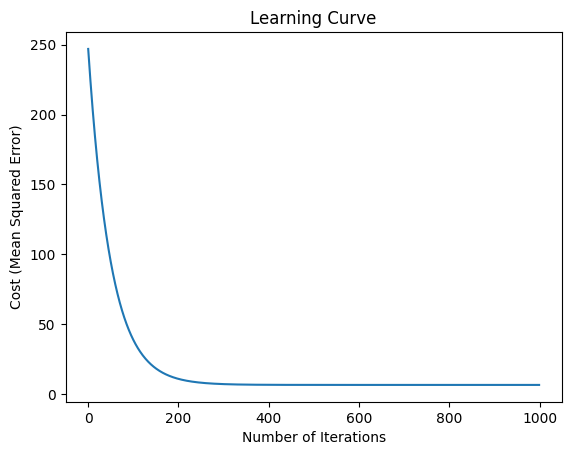

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the preprocessed dataset for cars
cars_data = pd.read_csv("cars.csv")

# Function to normalize features
def normalize_features(X):
    return (X - X.mean()) / X.std()

# Function to initialize parameters (weights and bias)
def initialize_parameters(num_features):
    # Initialize weights to zeros and bias to zero
    theta = np.zeros((num_features, 1))
    return theta

# Function to compute the cost (loss) function
def compute_cost(X, y, theta):
    m = len(y)
    predictions = np.dot(X, theta)
    squared_errors = np.square(predictions - y)
    J = (1 / (2 * m)) * np.sum(squared_errors)
    return J

# Function to perform gradient descent
def gradient_descent(X, y, theta, learning_rate, num_iterations):
    m = len(y)
    cost_history = []
    for i in range(num_iterations):
        predictions = np.dot(X, theta)
        errors = predictions - y
        gradient = (1 / m) * np.dot(X.T, errors)
        theta -= learning_rate * gradient
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history  # Return theta and cost_history

# Function to perform K-Fold Cross-Validation
def k_fold_cross_validation(X, y, k, learning_rate, num_iterations):
    m = len(y)
    fold_size = m // k
    mse_scores = []
    
    for fold in range(k):
        # Split data into training and validation sets for this fold
        start_idx = fold * fold_size
        end_idx = (fold + 1) * fold_size
        
        X_train = np.concatenate((X[:start_idx], X[end_idx:]), axis=0)
        y_train = np.concatenate((y[:start_idx], y[end_idx:]), axis=0)
        
        X_val = X[start_idx:end_idx]
        y_val = y[start_idx:end_idx]
        
        # Normalize features
        X_train_normalized = normalize_features(X_train)
        X_val_normalized = normalize_features(X_val)
        
        # Add bias term (intercept)
        X_train_normalized_with_bias = np.c_[np.ones((X_train_normalized.shape[0], 1)), X_train_normalized]
        X_val_normalized_with_bias = np.c_[np.ones((X_val_normalized.shape[0], 1)), X_val_normalized]
        
        # Initialize parameters
        num_features = X_train_normalized_with_bias.shape[1]
        theta = initialize_parameters(num_features)
        
        # Perform gradient descent
        theta, cost_history = gradient_descent(X_train_normalized_with_bias, y_train, theta, learning_rate, num_iterations)


        # Compute mean squared error for this fold
        predictions = np.dot(X_val_normalized_with_bias, theta)
        mse = np.mean(np.square(predictions - y_val))
        mse_scores.append(mse)
        
    return np.mean(mse_scores)

# Function to plot learning curve
def plot_learning_curve(cost_history):
    plt.plot(range(len(cost_history)), cost_history)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost (Mean Squared Error)")
    plt.title("Learning Curve")
    plt.show()

# Feature selection
selected_features = ["Horsepower"]
X = cars_data[selected_features].values
y = cars_data["Price in Thousands"].values.reshape(-1, 1)

# Hyperparameters
learning_rate = 0.01
num_iterations = 1000
k = 5  # Number of folds for cross-validation

# Perform K-Fold Cross-Validation
mse_score = k_fold_cross_validation(X, y, k, learning_rate, num_iterations)

print("Mean Squared Error (MSE) across {} folds: {:.4f}".format(k, mse_score))

# Plot learning curve
plot_learning_curve(cost_history)


PART 4
Comparison with Built-in Python Libraries

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Load the preprocessed dataset for cars
cars_data = pd.read_csv("cars.csv")

# Feature selection
selected_features = ["Horsepower"]
X = cars_data[selected_features].values
y = cars_data["Price in Thousands"].values.reshape(-1, 1)

# Implement Multivariate Regression using scikit-learn
model_lr = LinearRegression()
model_lr.fit(X, y)

# Predictions
predictions_lr = model_lr.predict(X)

# Compute mean squared error (MSE)
mse_lr = mean_squared_error(y, predictions_lr)

print("Mean Squared Error (MSE) using scikit-learn Linear Regression: {:.4f}".format(mse_lr))

# Implement K-Fold Cross-Validation using scikit-learn
cv_scores = cross_val_score(model_lr, X, y, cv=5, scoring='neg_mean_squared_error')
mse_cv = -cv_scores.mean()

print("Mean Squared Error (MSE) using scikit-learn K-Fold Cross-Validation: {:.4f}".format(mse_cv))


Mean Squared Error (MSE) using scikit-learn Linear Regression: 11.5348
Mean Squared Error (MSE) using scikit-learn K-Fold Cross-Validation: 12.3493
